# statistical-machine-learning-models

In [132]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from copy import copy
import seaborn as sns
import matplotlib.pyplot as plt

### Structure of the problem task is:
X 
    - ['date', 'SKU', 'Category', 'geoCluster', 'Group', 'price']

Y
    - ['qty']


In [118]:
sales = pd.read_csv("../data/processed/nts_v1.csv", parse_dates=['date'])
sales.head()

,date,SKU,Category,geoCluster,Group,price,qty
0,2020-01-27,534443,"Water, import, sparkling",2065,Mineral water,40.59,1.0
1,2020-02-26,233272,"Water, import, sparkling",2065,Mineral water,32.79,2.0
2,2020-02-27,233272,"Water, import, sparkling",2065,Mineral water,32.79,2.0
3,2020-03-03,233272,"Water, import, sparkling",2065,Mineral water,36.89,2.0
4,2020-04-01,787133,Avocado,2016,Tropical fruits,79.59,4.0


#### Convert date column to columns that can be processed by ML models

In [119]:
sales["year"] = sales.date.apply(lambda x: x.year)
sales["month"] = sales.date.apply(lambda x: x.month)
sales["week"] = sales.date.apply(lambda x: x.week)
sales["day_of_week"] = sales.date.apply(lambda x: x.dayofweek)
sales = sales.drop("date", axis="columns")

## Convert categorical columns to numeric

In [120]:
category = sales.Category.unique()
category = zip(category, np.random.randint(1000,9999, size=(len(category))))
category = dict(category)
sales.replace({"Category": category}, inplace=True)

group = sales.Group.unique()
group = zip(group, np.random.randint(1000,9999, size=(len(group))))
group= dict(group)
sales.replace({"Group": group}, inplace=True)

In [121]:
sales.head()

,SKU,Category,geoCluster,Group,price,qty,year,month,week,day_of_week
0,534443,7875,2065,8670,40.59,1.0,2020,1,5,0
1,233272,7875,2065,8670,32.79,2.0,2020,2,9,2
2,233272,7875,2065,8670,32.79,2.0,2020,2,9,3
3,233272,7875,2065,8670,36.89,2.0,2020,3,10,1
4,787133,1880,2016,9356,79.59,4.0,2020,4,14,2


In [123]:
X = sales.loc[:, sales.columns != 'qty']
y = sales['qty']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [124]:
def minimum_preprocessing(X, y):
    print('Original shape:{}'.format(X.shape))
    categorical_columns = X.dtypes[X.dtypes == 'object'].index.values
    # We kill categorical columns
    X=X.drop(columns=categorical_columns)
    print('Droped: {}'.format(categorical_columns))
    # We remove missing values
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y

X_train, y_train = minimum_preprocessing(X_train,y_train)
X_test, y_test = minimum_preprocessing(X_test,y_test)

Original shape:(622168, 9)
Droped: []
New shape:(622168, 9)
Original shape:(155543, 9)
Droped: []
New shape:(155543, 9)


## Basic Prediction

In [127]:
# We instantiate a linear regression. 
lr = LinearRegression()

# Now we train it on train data with fit method
lr.fit(X_train,y_train)

# We can predict using the predict method
y_pred = lr.predict(X_train)

weights = lr.coef_
intercept = lr.intercept_
# You can access to some info about the model, like the weights.
print('Coefficients: \n', weights[:10])
print('Intercept: \n', intercept)


# You can also use sklearn implementation
mean_square_error_sk = mean_squared_error(y_train, y_pred)
print( f"Train Mean Squared Error (MSE): {mean_square_error_sk}" )

cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

kf = KFold(n_splits=5)
i=1
for train_index, test_index in kf.split(X_train):
    print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,6) if j != i]))
    
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]

    lr = LinearRegression()
    lr.fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse = mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    print('\tMSE: {} NMSE: {} R2: {}'.format(fold_mse,fold_nmse, fold_r2) )

    cross_val_metrics.loc['Fold {}'.format(i), :] = [fold_mse,fold_nmse, fold_r2]
    i+=1
    
    
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

Coefficients: 
 [-7.39170335e-07  2.39808484e-04 -1.64372412e-04  2.12554705e-04
 -1.32255958e-02  5.15703644e-01  8.26604757e-02 -8.61812931e-03
  2.29117148e-02]
Intercept: 
 -1040.078192308998
Train Mean Squared Error (MSE): 18.312618297660755
Split 1: 
	Test Folds: [1] 
	Train Folds [2, 3, 4, 5]
	MSE: 19.576417299433047 NMSE: 0.9026336270965133 R2: 0.09736637290348671
Split 2: 
	Test Folds: [2] 
	Train Folds [1, 3, 4, 5]
	MSE: 18.576743147102803 NMSE: 0.8967675721045977 R2: 0.10323242789540232
Split 3: 
	Test Folds: [3] 
	Train Folds [1, 2, 4, 5]
	MSE: 17.293236606825616 NMSE: 0.8903735656878441 R2: 0.10962643431215591
Split 4: 
	Test Folds: [4] 
	Train Folds [1, 2, 3, 5]
	MSE: 17.952104722235863 NMSE: 0.8917800146393311 R2: 0.1082199853606689
Split 5: 
	Test Folds: [5] 
	Train Folds [1, 2, 3, 4]
	MSE: 18.16952728866292 NMSE: 0.8888127074689555 R2: 0.11118729253104453


,MSE,norm_MSE,R2
Fold 1,19.576417,0.902634,0.097366
Fold 2,18.576743,0.896768,0.103232
Fold 3,17.293237,0.890374,0.109626
Fold 4,17.952105,0.89178,0.10822
Fold 5,18.169527,0.888813,0.111187
Mean,18.313606,0.894073,0.105927


### View predictions

In [128]:
y_test_pred = lr.predict(X_test)

/home/teemo/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [129]:
y_test_pred = pd.Series(y_test_pred, name="qty^")
y_test_pred.index = y_test.index
df_temp = pd.concat([X_test, y_test], axis=1)
pd.concat([df_temp, y_test_pred], axis=1)

,SKU,Category,geoCluster,Group,price,year,month,week,day_of_week,qty,qty^
86397,440815,9387,2542,8670,47.69,2020,9,37,2,5.0,4.818156
472395,134544,2555,2482,9356,90.29,2021,3,12,3,2.7,3.270361
439298,32550,2922,2029,9356,53.89,2021,3,10,6,2.2,4.066647
168288,437495,6528,2032,6339,19.99,2020,11,48,4,4.0,4.205990
376646,440815,9387,2542,8670,47.69,2021,2,7,4,6.0,5.054662
...,...,...,...,...,...,...,...,...,...,...,...
449121,552806,6362,2064,6339,36.99,2021,3,11,3,8.0,4.003404
566876,1008,7875,2578,8670,31.29,2021,4,16,5,15.0,5.337055
147360,787133,1880,2069,9356,85.99,2020,11,46,5,3.0,2.651992
393408,567970,2868,2214,6339,26.39,2021,2,8,4,4.0,3.240342


## Understanding the model

In [130]:
weights = pd.DataFrame({'lr':lr.coef_}, index=X_train.columns)
weights.T

,SKU,Category,geoCluster,Group,price,year,month,week,day_of_week
lr,-7.352334e-07,0.000238,-0.000165,0.000213,-0.013125,0.514153,0.082888,-0.00866,0.021388


<AxesSubplot:>

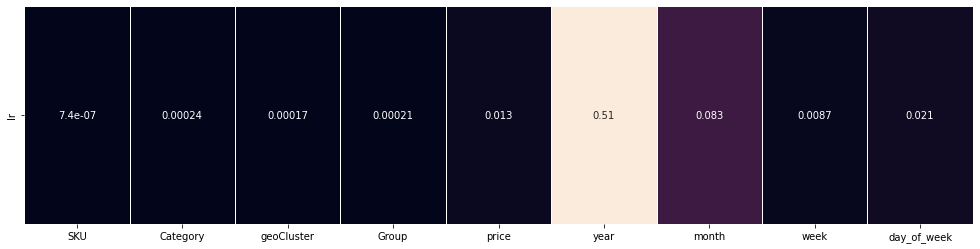

In [139]:
fig,  ax = plt.subplots( figsize = (17,4))
sns.heatmap(weights.T.loc[['lr'],:].abs(), annot=True, linewidths=.5, ax=ax, cbar=False, xticklabels=True)